<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/See_Food_v2_WORKING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# See Food v2

In [1]:
!pip install albumentations

In [2]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
from sklearn.preprocessing import LabelBinarizer

import joblib
import argparse
import albumentations
from imutils import paths

from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
else:
  print(device)

Tesla T4


In [5]:
# download and unzip locally

downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

;

mkdir: cannot create directory ‘data’: File exists
/content/data
--2020-12-04 02:23:47--  https://docs.google.com/uc?export=download&confirm=2IoE&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV
Resolving docs.google.com (docs.google.com)... 74.125.142.138, 74.125.142.139, 74.125.142.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-bc-docs.googleusercontent.com/docs/securesc/e2cpriqv6k6funan060j6dn5i292qpvc/99pdod0j01khrl6512ocbas7b7no3l3u/1607048625000/10490392775048702533/13740170554122340471Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download [following]
--2020-12-04 02:23:48--  https://doc-0c-bc-docs.googleusercontent.com/docs/securesc/e2cpriqv6k6funan060j6dn5i292qpvc/99pdod0j01khrl6512ocbas7b7no3l3u/1607048625000/10490392775048702533/13740170554122340471Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download
Resolving doc-0c-bc-docs.googleusercontent.com (doc-0c-bc-docs.googleuser

''

In [5]:
def mount_gdrive():
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Kaggle/See_Food')
    !ls

colab=False

if colab:
    mount_gdrive()

In [6]:
# unzip data file

zip=False

if zip:
  %cd data
  !unzip final-project-food-recognition-challenge.zip
  %cd ..

In [4]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('data/train_labels.csv')
path = 'data/train_set/train_set/'

data = pd.DataFrame()
data['image_path'] = path+df.img_name.values
labels = np.array(df.label.values)

# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping an one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(labels)}")
for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)
# save as csv file
data.to_csv('data/labelized.csv', index=False)
# pickle the label binarizer
joblib.dump(lb, 'data/lb.pkl')
print('Save the one-hot encoded binarized labels as a pickled file.')
print(data.head())

The first one hot encoded labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Mapping an one hot encoded label to its category: 1
Total instances: 30612
Save the one-hot encoded binarized labels as a pickled file.
                                 image_path  target
0  data/train_set/train_set/train_12631.jpg    59.0
1   data/train_set/train_set/train_1536.jpg    70.0
2  data/train_set/train_set/train_23949.jpg    75.0
3  data/train_set/train_set/train_17295.jpg    37.0
4   data/train_set/train_set/train_6596.jpg    69.0


In [5]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('data/labelized.csv')
X = df.image_path.values
y = df.target.values

In [6]:
# # read the data.csv file and get the image paths and labels
# df = pd.read_csv('data/train_labels.csv')
# path = 'data/train_set/train_set/'

# # reindex label values to 0
# df.label = df.label-1

# X = path+df.img_name.values
# y = df.label.values
# # print(X)


In [7]:
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.25, random_state=42))

In [8]:
# image dataset module
class NaturalImageDataset(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.HorizontalFlip(p=1.0),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=30,
                    p=1.0
                ),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [9]:
train_data = NaturalImageDataset(xtrain, ytrain, tfms=1)
test_data = NaturalImageDataset(xtest, ytest, tfms=0)
 
# dataloaders
on_gpu=True
if on_gpu:
  batch_size=1024 
else:
  batch_size=128

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [11]:
# lb = LabelBinarizer()
# lb.fit_transform(y)
# lb.classes_

# load the binarized labels
print('Loading label binarizer...')
lb = joblib.load('data/lb.pkl')

Loading label binarizer...


In [12]:
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    model.fc = nn.Linear(2048, len(lb.classes_))
    return model
model = model(pretrained=True, requires_grad=False).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
# loss function
criterion = nn.CrossEntropyLoss()

In [14]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        
        # print("outputs",outputs.shape,outputs)
        # print("target",target.shape,target)
        ## I dont know why this works but needed to subtract 1 from target
        loss = criterion(outputs, target)
        
        
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [15]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)

            ## I dont know why this works but needed to subtract 1 from target
            loss = criterion(outputs, target)            
                        
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(test_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [16]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 of 5
Training


23it [03:11,  8.31s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 1.55
Validating


8it [00:58,  7.33s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 1.46
Epoch 2 of 5
Training


23it [03:14,  8.46s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 1.63
Validating


8it [00:58,  7.31s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 1.69
Epoch 3 of 5
Training


23it [03:15,  8.50s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 1.82
Validating


8it [00:58,  7.27s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 1.67
Epoch 4 of 5
Training


23it [03:16,  8.56s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 1.97
Validating


8it [00:59,  7.39s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 1.79
Epoch 5 of 5
Training


23it [03:17,  8.60s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 2.24
Validating


8it [00:58,  7.32s/it]

Val Loss: 0.0046, Val Acc: 1.84
21.153 minutes


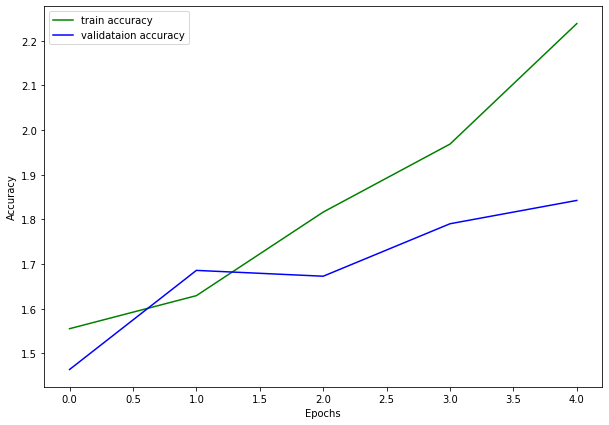

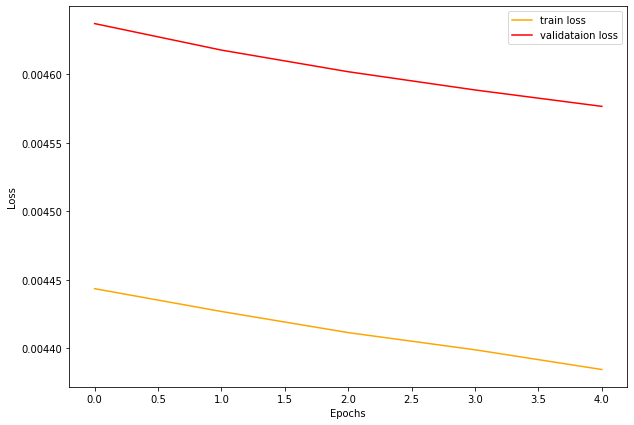

In [24]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('outputs/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()

In [41]:
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'outputs/model.pth')

Saving model...


Load Saved Model

In [13]:
load_model = True

if load_model:
  %cd outputs
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IMvMnZnJa8xNqMvi2xkqOxnoF6CW9bR4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1IMvMnZnJa8xNqMvi2xkqOxnoF6CW9bR4" -O model.pth && rm -rf /tmp/cookies.txt
  %cd ..

/content/outputs
--2020-12-03 03:23:15--  https://docs.google.com/uc?export=download&confirm=loFx&id=1IMvMnZnJa8xNqMvi2xkqOxnoF6CW9bR4
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.113, 74.125.142.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-6s-docs.googleusercontent.com/docs/securesc/mla0ntrc9fo06fl0tsmt6do2mfivnlkv/hi10dfdd8n3fa2psu5kgu48tjb24khb3/1606965750000/10490392775048702533/12898819547445006094Z/1IMvMnZnJa8xNqMvi2xkqOxnoF6CW9bR4?e=download [following]
--2020-12-03 03:23:15--  https://doc-14-6s-docs.googleusercontent.com/docs/securesc/mla0ntrc9fo06fl0tsmt6do2mfivnlkv/hi10dfdd8n3fa2psu5kgu48tjb24khb3/1606965750000/10490392775048702533/12898819547445006094Z/1IMvMnZnJa8xNqMvi2xkqOxnoF6CW9bR4?e=download
Resolving doc-14-6s-docs.googleusercontent.com (doc-14-6s-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c

In [14]:
!ls

data  outputs  sample_data


In [14]:
'''MODEL'''
# model = model(pretrained=False, requires_grad=False).to(device)
model.load_state_dict(torch.load('outputs/model.pth'))
print('Model loaded')

Model loaded


In [42]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('data/sample.csv')
path = 'data/test_set/test_set/'

X = path+df.img_name.values
y = df.label.values
print(X)

['data/test_set/test_set/test_1.jpg' 'data/test_set/test_set/test_2.jpg'
 'data/test_set/test_set/test_3.jpg' ...
 'data/test_set/test_set/test_7651.jpg'
 'data/test_set/test_set/test_7652.jpg'
 'data/test_set/test_set/test_7653.jpg']


In [43]:
test_data = NaturalImageDataset(X, y, tfms=0)
df_test = df.copy()
# dataloaders
testloader = DataLoader(test_data, batch_size=1024, shuffle=False)

In [44]:
#inference function
def predict(model, test_dataloader):
    print('predicting...')
    model.eval()
    predict_df = pd.DataFrame()
    val_running_loss = 0.0
    val_running_correct = 0
    all_predictions = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
 
            ## I dont know why this works but needed to subtract 1 from target
            # loss = criterion(outputs, target-1)            
                        
            # val_running_loss += loss.item()
            
            outputs = model(data).cpu()
            _, preds = torch.max(outputs.data, 1)
            for i in preds:
                all_predictions.append(lb.classes_[i])

            # df_test.label.iloc[i] = lb.classes_[preds]
            # print(preds)
            # print(lb.classes_[preds])

            # val_running_correct += (preds == target).sum().item()

            # predictions = list(model(data.to(device)).cpu().numpy())
            # for prediction in predictions:
            #     all_predictions.append(lb.classes_[predictions])
        
        # val_loss = val_running_loss/len(test_dataloader.dataset)
        # val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        # print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return all_predictions

In [21]:
torch.cuda.empty_cache()

In [45]:
predictions = predict(model, testloader)

  0%|          | 0/7 [00:00<?, ?it/s]

predicting...


8it [01:00,  7.54s/it]


In [46]:
print(type(predictions))
print(len(predictions))
print(predictions[:20])

<class 'list'>
7653
[57, 57, 38, 29, 22, 1, 49, 37, 30, 49, 23, 29, 57, 69, 57, 46, 57, 57, 57, 24]


In [47]:
df.label = predictions

In [48]:
df.head()

,img_name,label
0,test_1.jpg,57
1,test_2.jpg,57
2,test_3.jpg,38
3,test_4.jpg,29
4,test_5.jpg,22


In [29]:
df.to_csv(r'kaggle_output.csv', index = False)

In [44]:
# _ = predict(model, testloader)
# df_test.head()

  0%|          | 0/29 [00:00<?, ?it/s]

predicting...


  0%|          | 0/29 [00:01<?, ?it/s]


TypeError: ignored

torch.Size([1, 3, 256, 455])
Predicted output: 1


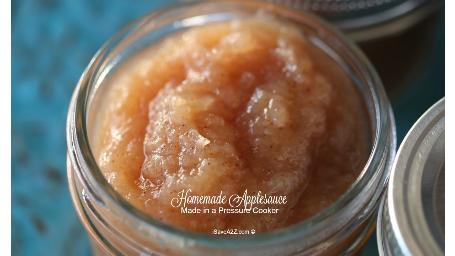

torch.return_types.max(
values=tensor([322.4124], device='cuda:0'),
indices=tensor([0], device='cuda:0'))
tensor([0], device='cuda:0')
tensor([[ 322.4124,   93.1120,  172.0795,  -64.8271,  -12.3033, -168.0296,
           10.7717, -290.5796,   54.3586,  152.5023,  -10.5823,   -8.9006,
         -151.8733,  -61.7039,  -81.1888,  -18.9064,  -95.4341,   91.2492,
           11.5210, -248.7808,  -51.1956,   -9.8348, -120.8049,  -70.8862,
         -139.0565, -238.7733, -146.7195,    8.9503,  -71.5172,   38.5768,
           58.5169,  -20.7586,  -14.9884, -175.3370,  183.5403,  -35.2527,
          161.9468,   56.0671,   21.8380,   68.2683,  119.6008, -105.9575,
          -57.2916,  -97.7305,   17.2682,  143.2007, -140.5065,   45.8991,
           -0.8736,   -4.8874,  -21.7222,   44.5554,  222.2246,   95.1095,
         -136.6682,  102.2023,   85.8560,  146.0035,   77.3049,  -88.5825,
          -72.7544,   63.2420, -121.2163,  -32.0576, -114.7423,  -84.9039,
          128.1579,  -76.6080,   -9.7074

In [55]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from random import randint

img_path = X[randint(0,len(X))]
image = cv.imread(img_path)
image_copy = image.copy()
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float).cuda()
image = image.unsqueeze(0)
print(image.shape)
outputs = model(image)
_, preds = torch.max(outputs.data, 1)
print(f"Predicted output: {lb.classes_[preds]}")
# cv.putText(image_copy, lb.classes_[preds], (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2_imshow(image_copy)
cv.imwrite(img_path, image_copy)
cv.waitKey(0)
print(torch.max(outputs.data, 1))
print(preds)
print(outputs)